In [1]:

# Given a list of points representing the vertices
points_8v = [[ 1.98040992,  0.66953732,  1.2808793 ],
       [ 0.66953732,  1.98040992, -1.2808793 ],
       [-0.66953732, -1.98040992, -1.2808793 ],
       [-1.98040992,  0.66953732, -1.2808793 ],
       [ 1.98040992, -0.66953732, -1.2808793 ],
       [-0.66953732,  1.98040992,  1.2808793 ],
       [ 0.66953732, -1.98040992,  1.2808793 ],
       [-1.98040992, -0.66953732,  1.2808793 ]]

points_tetrahedron = [[0.66953732, 1.98040992, 3.6876207 ], [1.2743144, 3.9482856, 1.7658049], [-0.66953732,  1.98040992,  1.2808793 ], [-1.2743144,  3.9482856,  3.2026951]]

points_octa = [[4.553062680000001, 3.24219008, 1.2808793], [1.9804099199999998, 0.66953732, 1.2808793], [1.2743144000000002, 3.9482856000000006, 1.7658048999999996], [0.66953732, 1.9804099199999998, -1.2808793], [3.24219008, 4.553062680000001, -1.2808793], [3.9482856000000006, 1.2743144000000002, -1.7658048999999996]]

points_18_v_pentagonal_prism = [[1.4883631600000002, 0.0, 1.4883631600000002], [1.4883631600000002, 1.4883631600000002, 0.0], [0.0, 1.4883631600000002, 1.4883631600000002], [2.00382078, 0.0, 0.0], [-2.003820779999999, 0.0, 0.0], [0.0, 2.00382078, 0.0], [0.0, -2.003820779999999, 0.0], [0.0, 0.0, 2.00382078], [0.0, 0.0, -2.003820779999999], [0.0, -1.48836316, -1.48836316], [1.4883631600000002, 0.0, -1.48836316], [1.4883631600000002, -1.48836316, 0.0], [0.0, 1.4883631600000002, -1.48836316], [-1.48836316, 0.0, -1.48836316], [-1.48836316, 1.4883631600000002, 0.0], [0.0, -1.48836316, 1.4883631600000002], [-1.48836316, 0.0, 1.4883631600000002], [-1.48836316, -1.48836316, 0.0]]

In [22]:
points = points_8v

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def shapes_count(shapes_in_faces: list[list[tuple]]) -> dict:
    shapes_vertex_count = {}
    
    for shape in shapes_in_faces:
        n_vertex = len(shape)
        done_vertexs = []
        for pair in shape:
            for idx_vertex in pair:
                if idx_vertex not in done_vertexs:
                    done_vertexs.append(idx_vertex)
                    if str(idx_vertex) in shapes_vertex_count:
                        if str(n_vertex) in shapes_vertex_count[str(idx_vertex)]:
                            shapes_vertex_count[str(idx_vertex)][str(n_vertex)] += 1
                        else:
                            shapes_vertex_count[str(idx_vertex)][str(n_vertex)] = 1
                    else:
                        shapes_vertex_count[str(idx_vertex)] = {}
                        shapes_vertex_count[str(idx_vertex)][str(n_vertex)] = 1
                    
    return shapes_vertex_count

def get_polyhedron_edges(points, tol=1e-6):
    points = np.asarray(points)
    hull = ConvexHull(points)
    simplices = hull.simplices  
    shapes_2d = []
    
    def normalize_vector(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            return v
        v = v / norm
        if v[0] < 0 or (v[0] == 0 and v[1] < 0) or (v[0] == 0 and v[1] == 0 and v[2] < 0):
            v = -v
        return v
    
    plane_dict = {}
    for i, simplex in enumerate(simplices):
        A, B, C = points[simplex]
        
        # vectors of edges
        AB = B - A
        AC = C - A

        N = np.cross(AB, AC)
        N = normalize_vector(N)

        D = -np.dot(N, A)

        N_rounded = tuple(np.round(N / tol) * tol)
        D_rounded = np.round(D / tol) * tol

        plane_key = N_rounded + (D_rounded,)

        if plane_key not in plane_dict:
            plane_dict[plane_key] = []
        plane_dict[plane_key].append(simplex)
    
    # found edges for every polygon
    edge_set = set()
    for simplices_in_plane in plane_dict.values():
        edges_in_face = []
        for simplex in simplices_in_plane:
            # edges of triangle
            edges = [
                tuple(sorted([simplex[0], simplex[1]])),
                tuple(sorted([simplex[1], simplex[2]])),
                tuple(sorted([simplex[2], simplex[0]]))
            ]
            edges_in_face.extend(edges)
        edge_counts = Counter(edges_in_face)
        # if found just 1 edge -> this is the outer side
        boundary_edges = [edge for edge, count in edge_counts.items() if count == 1]
        shapes_2d.append(boundary_edges)
        edge_set.update(boundary_edges)
    
    polyhedron_edges = list(edge_set)
    shapes_vertex_map = shapes_count(shapes_2d)
    return polyhedron_edges, shapes_vertex_map

def plot_polyhedron(points, edges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    points = np.array(points)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="red", s=50)
    
    edge_points = [[points[edge[0]], points[edge[1]]] for edge in edges]
    edge_lines = Line3DCollection(edge_points, colors="blue", linewidths=1.5)
    ax.add_collection3d(edge_lines)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Polyhedron")
    plt.show()


edges, shapes_vertex_map = get_polyhedron_edges(points)
print("Number of edges of poly:", len(edges))

plot_polyhedron(points, edges)

Number of edges of poly: 21
Faces:
Face 1: [(0.11152948902167525, 0.9608410483907901, 0.7486717480827081), (0.07398360822377636, 0.11551214943864818, 0.5417682017962124), (0.7777976812395722, 0.05624980708625782, 0.21297271921010685)]
Face 2: [(0.5767734122070646, 0.8929668456264399, 0.9600728588358249), (0.9949906505122266, 0.28020270331900465, 0.9775729617776316), (0.07398360822377636, 0.11551214943864818, 0.5417682017962124)]
Face 3: [(0.11152948902167525, 0.9608410483907901, 0.7486717480827081), (0.5767734122070646, 0.8929668456264399, 0.9600728588358249), (0.07398360822377636, 0.11551214943864818, 0.5417682017962124)]
Face 4: [(0.5767734122070646, 0.8929668456264399, 0.9600728588358249), (0.9949906505122266, 0.28020270331900465, 0.9775729617776316), (0.8100347341060177, 0.6356957826929417, 0.5191256450852042)]
Face 5: [(0.705084802981688, 0.08214761420209549, 0.37593692815266166), (0.07398360822377636, 0.11551214943864818, 0.5417682017962124), (0.9949906505122266, 0.28020270331900

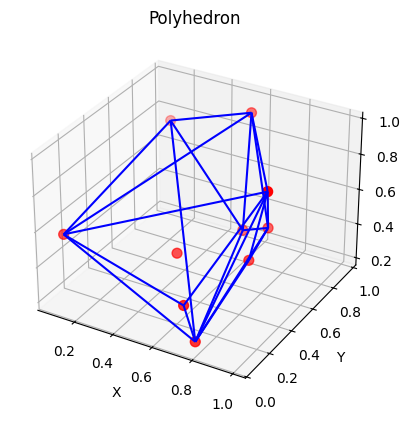

In [16]:
import numpy as np
from scipy.spatial import ConvexHull
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def get_polyhedron_edges(points, tol=1e-6):
    points = np.asarray(points)
    hull = ConvexHull(points)
    simplices = hull.simplices  
    
    def normalize_vector(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            return v
        v = v / norm
        if v[0] < 0 or (v[0] == 0 and v[1] < 0) or (v[0] == 0 and v[1] == 0 and v[2] < 0):
            v = -v
        return v
    
    plane_dict = {}
    for i, simplex in enumerate(simplices):
        A, B, C = points[simplex]
        
        # vectors of edges
        AB = B - A
        AC = C - A

        N = np.cross(AB, AC)
        N = normalize_vector(N)

        D = -np.dot(N, A)

        N_rounded = tuple(np.round(N / tol) * tol)
        D_rounded = np.round(D / tol) * tol

        plane_key = N_rounded + (D_rounded,)

        if plane_key not in plane_dict:
            plane_dict[plane_key] = []
        plane_dict[plane_key].append(simplex)
    
    # found edges for every polygon
    edge_set = set()
    for simplices_in_plane in plane_dict.values():
        edges_in_face = []
        for simplex in simplices_in_plane:
            # edges of triangle
            edges = [
                tuple(sorted([simplex[0], simplex[1]])),
                tuple(sorted([simplex[1], simplex[2]])),
                tuple(sorted([simplex[2], simplex[0]]))
            ]
            edges_in_face.extend(edges)
        edge_counts = Counter(edges_in_face)
        # if found just 1 edge -> this is the outer side
        boundary_edges = [edge for edge, count in edge_counts.items() if count == 1]
        edge_set.update(boundary_edges)
    
    polyhedron_edges = list(edge_set)
    return polyhedron_edges, plane_dict

def get_faces(points, plane_dict):
    faces = []
    for simplices_in_plane in plane_dict.values():
        face_points = set()
        for simplex in simplices_in_plane:
            for index in simplex:
                face_points.add(tuple(points[index]))
        faces.append(list(face_points))
    return faces

def plot_polyhedron(points, edges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    points = np.array(points)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="red", s=50)
    
    edge_points = [[points[edge[0]], points[edge[1]]] for edge in edges]
    edge_lines = Line3DCollection(edge_points, colors="blue", linewidths=1.5)
    ax.add_collection3d(edge_lines)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Polyhedron")
    plt.show()


# Example usage
points = np.random.rand(10, 3)  # Example points
edges, plane_dict = get_polyhedron_edges(points)
faces = get_faces(points, plane_dict)

print("Number of edges of poly:", len(edges))
print("Faces:")
for i, face in enumerate(faces):
    print(f"Face {i+1}: {face}")

plot_polyhedron(points, edges)


In [1]:
from cifkit import Cif

cif = Cif("/root/projects/ml-selection/ml_selection/cif_from_gui/ZnS_MPDS_S304043.cif")
site_labels = cif.site_labels

# Loop through each site label
for label in site_labels:
    # Dipslay each polyhedron, .png saved for each label
    cif.plot_polyhedron(label, is_displayed=False, output_dir='.')

2024-12-04 14:08:34.743 (   3.147s) [    7F0A6CF41740]vtkXOpenGLRenderWindow.:1290  WARN| vtkXOpenGLRenderWindow (0x30ad4a0): bad X server connection. DISPLAY=
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

2024-12-04 14:08:34.759 (   3.163s) [    7F0A6CF41740] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x3053c00): EGL device index: 0 could not be initialized. Trying other devices...
2024-12-04 14:08:34.759 (   3.163s) [    7F0A6CF41740] vtkEGLRenderWindow.cxx:385   WARN| vtkEGLRenderWindow (0x3053c00): Setting an EGL display to device index: -1 require EGL_EXT_device_base EGL

: 

In [1]:
from cifkit import Cif, Example
import warnings
import logging
logging.basicConfig(level=logging.DEBUG)

warnings.filterwarnings('ignore') # For Jupyter Notebook only

# Initialize
cif = Cif(Example.ErCoIn5_file_path)

# Enter site labels. you can get site labels using cif.labels
print("Site labels:", cif.site_labels)

# Plot
cif.plot_polyhedron("In1", is_displayed=True)

Site labels: ['In2', 'In1', 'Co', 'Er']


2024-12-04 15:09:18.087 (   2.801s) [    7FBA9E7CB740]vtkXOpenGLRenderWindow.:1290  WARN| vtkXOpenGLRenderWindow (0x4625e90): bad X server connection. DISPLAY=
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

2024-12-04 15:09:18.103 (   2.817s) [    7FBA9E7CB740] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x45e46f0): EGL device index: 0 could not be initialized. Trying other devices...
2024-12-04 15:09:18.103 (   2.817s) [    7FBA9E7CB740] vtkEGLRenderWindow.cxx:385   WARN| vtkEGLRenderWindow (0x45e46f0): Setting an EGL display to device index: -1 require EGL_EXT_device_base EGL

: 

In [1]:
import pyvista as pv
pv.start_xvfb()
